/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


UMPM
[GRAPHCUT] step1 elapsed: 1.2066612243652344
[GRAPHCUT] step2 elapsed: 0.014441728591918945
[GRAPHCUT] step3 elapsed: 0.009446859359741211
[GRAPHCUT] step4 elapsed: 9.7595853805542
elapsed 10.99213981628418


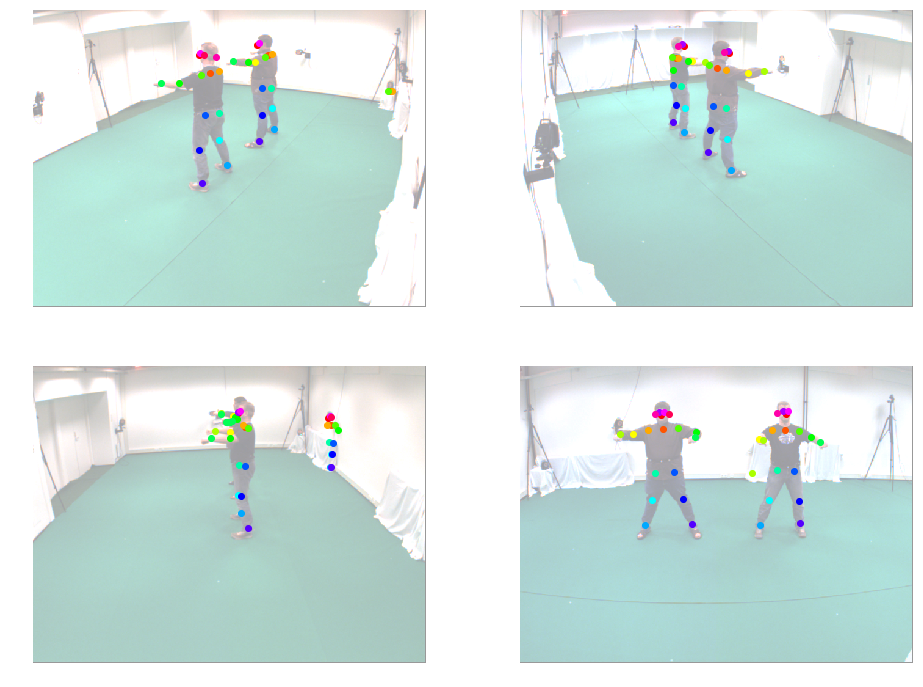

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../../settings.txt'))
print('\n')
# ------------------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os.path import isfile
import sys
from time import time
import cv2
import numpy as np
from os.path import join, isdir
sys.path.insert(0,'../../../easy_multi_person_pose_estimation')
sys.path.insert(0,'../../')
import mvpose.data.transform as tfm
import mvpose.geometry.geometry as gm
from mvpose.geometry import stereo
import mvpose.pose_estimation.heatmaps as mvhm
from mvpose.candidates import peaks as mvpeaks
import mvpose.pose_estimation.part_affinity_fields as mvpafs
from mvpose.data.default_limbs import  DEFAULT_LIMB_SEQ, DEFAULT_MAP_IDX
from mvpose.algorithm import graphcut
from cselect import color as cs

root = join(Settings['data_root'], 'pak')

from poseestimation import model
pe = model.PoseEstimator()


from pak.datasets.UMPM import UMPM
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']

X, Y, Calib = tfm.get_from_umpm(root, 'p2_free_1', user, pwd)
Human_Pose_Gt = Y

# interesting frames: [340, 215, 250]
FRAME = 0

Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])
with_gpu = False

if with_gpu:
    _start = time()
    heatmaps, pafs = pe.predict_pafs_and_heatmaps(I)
    _end = time(); print('elapsed:', _end - _start)
else:
    hm_file = '/tmp/heatmaps' + str(FRAME) + '.npy'
    paf_file = '/tmp/pafs' + str(FRAME) + '.npy'
    
    if isfile(hm_file) and isfile(paf_file):
        heatmaps = np.load(hm_file)
        pafs = np.load(paf_file)
    else:
        heatmaps = []; pafs = []
        for im in Im:
            _start = time()
            hm, paf = pe.predict_pafs_and_heatmaps(im)
            heatmaps.append(np.squeeze(hm))
            pafs.append(np.squeeze(paf))
            _end = time()
            print('elapsed:', _end - _start)
        heatmaps = np.array(heatmaps)
        pafs = np.array(pafs)
        np.save(hm_file, heatmaps)
        np.save(paf_file, pafs)
        
import mvpose.plot.limbs as pltlimbs

colors = cs.lincolor(19)/255

r = 200
_start = time()
Gr = graphcut.GraphCutSolver(heatmaps, pafs, Calib, r, debug=True)
_end = time()
print('elapsed', _end - _start)

fig = plt.figure(figsize=(16,12))

for idx, im in enumerate(Im):
    ax = fig.add_subplot(2,2,idx+1)
    ax.imshow(im, alpha=0.4)
    ax.axis('off')
    
    for jid in range(Gr.peaks2d[idx].n_joints):
        for x,y,score in Gr.peaks2d[idx][jid]:
            ax.scatter(x,y, color=colors[jid])
    
plt.show()

In [2]:
im.shape

(486, 644, 3)

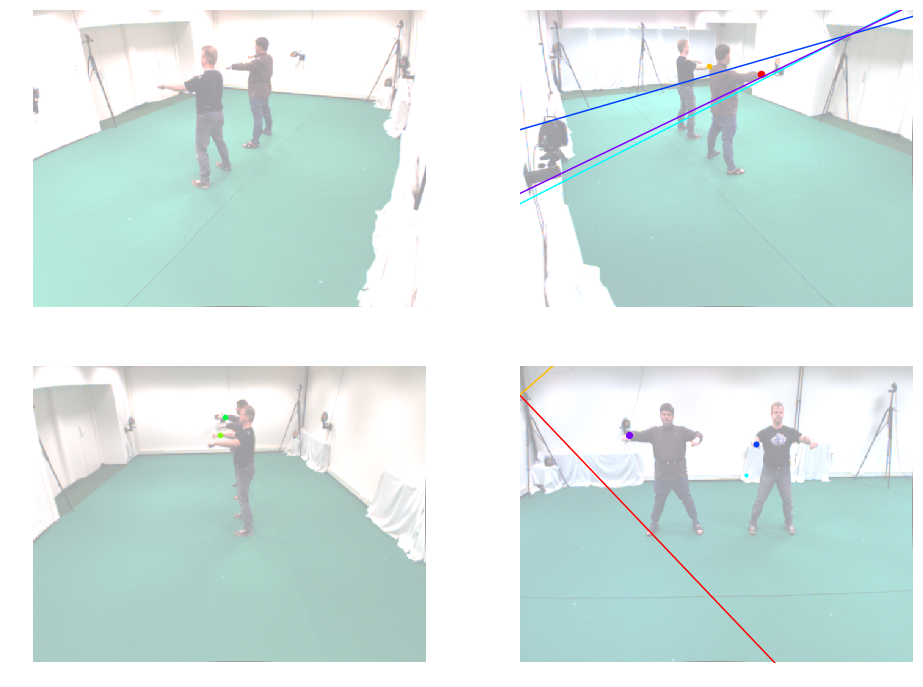

In [3]:
JOINT_ID = 4

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

choose_camera = (1, 3)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fig = plt.figure(figsize=(16,12))

COLORS = cs.lincolor(9)/255

pid = 0
color_lookup = {}
camera_ax = []
for idx, cam in enumerate(Gr.Calib_undistorted):
    ax = fig.add_subplot(2,2,1+idx)
    ax.set_xlim([0, 644])
    ax.set_ylim([486, 0])
    ax.axis('off')
    camera_ax.append(ax)
    
    im = Im[idx]
    mapx, mapy = Gr.undistort_maps[idx]
    im = cv2.remap(im, mapx, mapy, interpolation=cv2.INTER_LINEAR)
    
    ax.imshow(im, alpha=0.4)
    
    peaks2d = Gr.peaks2d_undistorted[idx][JOINT_ID]
    for cur_pid, (x,y,w) in enumerate(peaks2d):
        ax.scatter(x,y, alpha=1, s=w*50, color=COLORS[pid])
        color_lookup[idx, cur_pid] = COLORS[pid]
        pid += 1

# --- FUNDAMENTAL MATRIX ---
cid1, cid2 = choose_camera
K1, rvec1, tvec1, distCoef1 = gm.get_camera_parameters(Gr.Calib_undistorted[cid1])
K2, rvec2, tvec2, distCoef2 = gm.get_camera_parameters(Gr.Calib_undistorted[cid2])
assert distCoef1 == 0 and distCoef2 == 0

F = stereo.get_fundamental_matrix_flat(K1, rvec1, tvec1, 0,
                                       K2, rvec2, tvec2, 0)

peaks2d_a = Gr.peaks2d_undistorted[cid1][JOINT_ID]
peaks2d_b = Gr.peaks2d_undistorted[cid2][JOINT_ID]

epilines_1to2 = np.squeeze(
            cv2.computeCorrespondEpilines(peaks2d_a, 1, F))
epilines_2to1 = np.squeeze(
                cv2.computeCorrespondEpilines(peaks2d_b, 2, F))

if len(epilines_1to2.shape) > 0:
    for pid, (a, b, c) in enumerate(epilines_1to2):
        ax = camera_ax[cid2]
        color = color_lookup[cid1, pid]
        func = lambda a, b, c, x: -(a*x + c)/b
        x1 = 0; y1 = func(a,b,c,x1)
        x2 = 800; y2 = func(a,b,c,x2)
        ax.plot([x1, x2], [y1, y2], color=color)
    
for pid, (a, b, c) in enumerate(epilines_2to1):
    ax = camera_ax[cid1]
    color = color_lookup[cid2, pid]
    func = lambda a, b, c, x: -(a*x + c)/b
    x1 = 0; y1 = func(a,b,c,x1)
    x2 = 800; y2 = func(a,b,c,x2)
    ax.plot([x1, x2], [y1, y2], color=color)

plt.show()

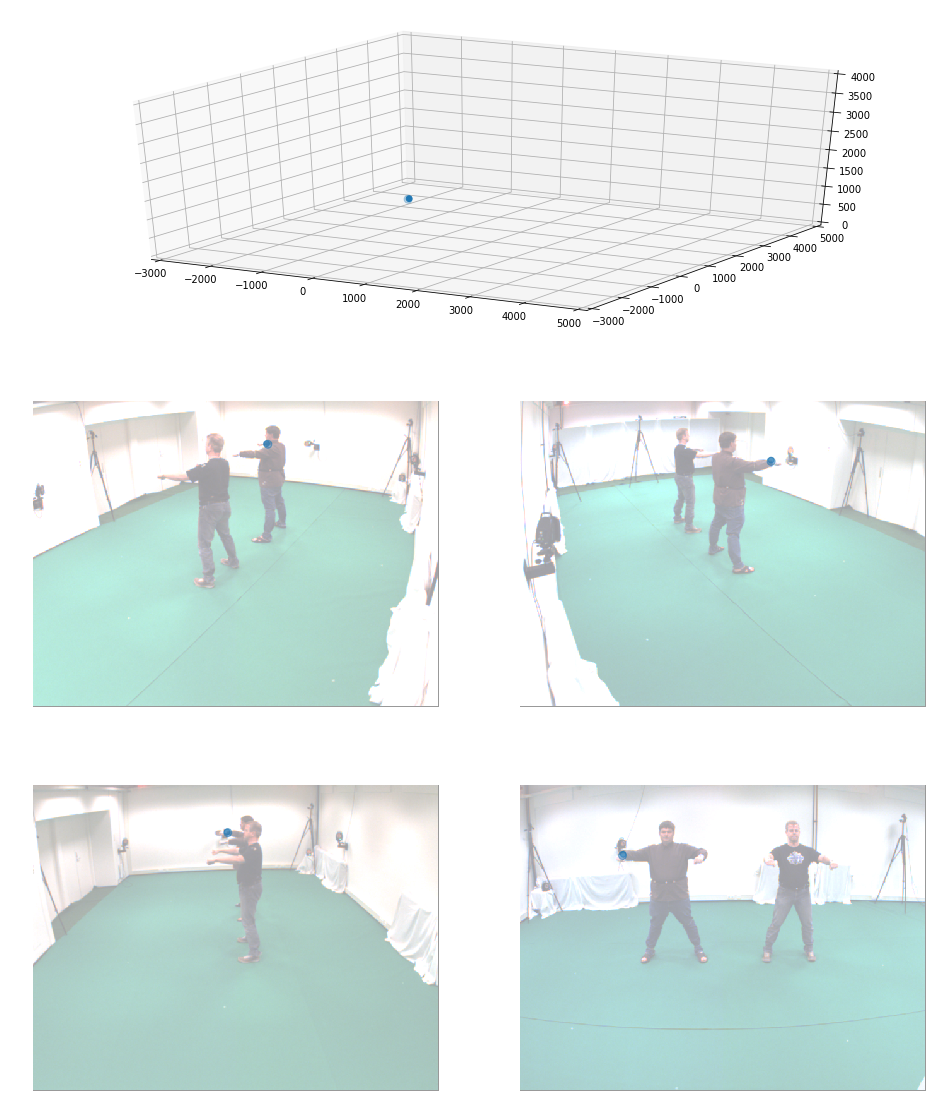

In [4]:
# 0 - Nose,  3 - relbow,  4 - rhand,  10 - rfoot,  12 - lknee,  13 - lfoot
JOINT_ID = 4

peaks = Gr.peaks3d_weighted[JOINT_ID]

fig = plt.figure(figsize=(16,20))
ax = fig.add_subplot(311, projection='3d')
ax.set_xlim([-3000, 5000])
ax.set_ylim([-3000, 5000])
ax.set_zlim([0, 4000])

X = peaks[:,0]
Y = peaks[:,1]
Z = peaks[:,2]
W = peaks[:,3] * peaks[:,4]

ax.scatter(X,Y,Z, s=W*100)

# --- reproject ---
Pts3d = peaks[:,0:3]
Pts3d = Pts3d.astype('float64')

for idx, cam in enumerate(Gr.Calib_undistorted):
    ax = fig.add_subplot(3,2,3+idx)
    ax.axis('off')
    
    im = Im[idx]
    
    ax.imshow(im, alpha=0.4)
    
    peaks2d = Gr.candidates2d[idx][JOINT_ID]
    
    x = peaks2d[:,0]
    y = peaks2d[:,1]
    W = peaks2d[:,2] *  peaks2d[:,3]
    ax.scatter(x,y, alpha=0.5, s=W*100)
    
    
plt.show()

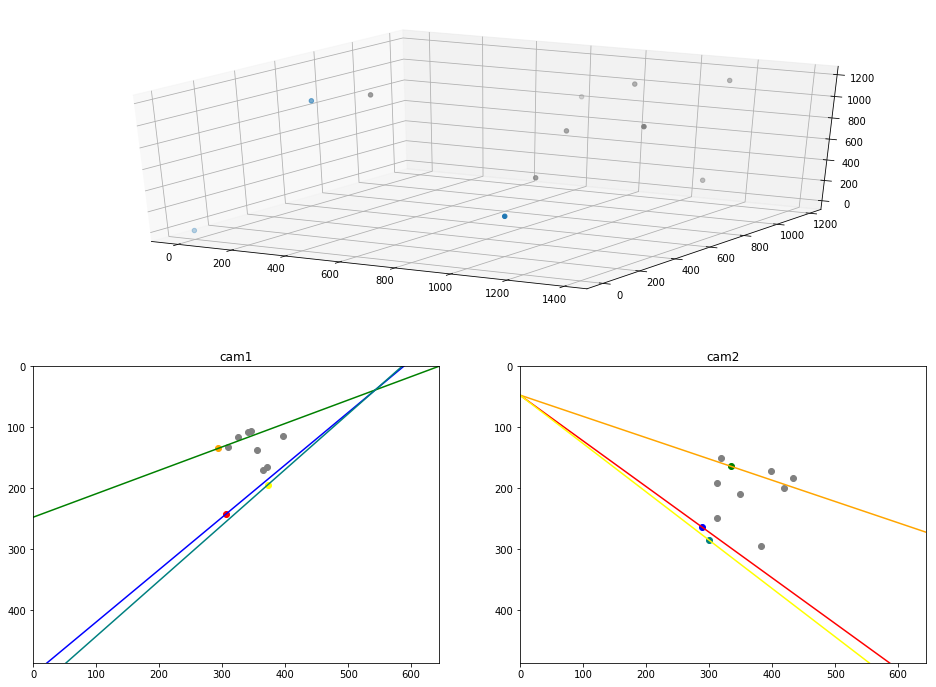

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import numpy.random as rnd
import cv2

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
K1 = np.array([
    [423.2, 0., 336.7],
    [  0., 454.7, 233.3],
    [0, 0, 1]
])
rvec1 = np.array([1.95295 , -0.504068,  0.354115])
tvec1 = np.array([-335.876 ,   89.9265, 4686.5])

K2 = np.array([
    [424.6,   0., 319.1],
    [  0., 455.9, 237.5],
    [  0.,   0.,   1.]])
rvec2 = np.array([1.49463,  1.50749, -1.02842])
tvec2 = np.array([-327.238,  249.454, 4468.67 ])
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# def get_world_coord(rvec, tvec):
#     R = cv2.Rodrigues(rvec)[0]
#     return -np.transpose(R) @ tvec

def get_projection_matrix(K, rvec, tvec):
    R = cv2.Rodrigues(rvec)[0]
    Rt = np.zeros((3,4))
    Rt[:,0:3] = R
    Rt[:,3] = tvec
    return K @ Rt

P1 = get_projection_matrix(K1, rvec1, tvec1)
P2 = get_projection_matrix(K2, rvec2, tvec2)

points3d = rnd.randint(0, 1500, (8, 3)).astype('float32')

#points2d_1 = P1 @ cv2.convertPointsToHomogeneous(points3d)

points2d_1 = np.squeeze(cv2.projectPoints(points3d, rvec1, tvec1, K1, 0)[0])
points2d_2 = np.squeeze(cv2.projectPoints(points3d, rvec2, tvec2, K2, 0)[0])


F, mask = cv2.findFundamentalMat(points2d_1, points2d_2, cv2.FM_8POINT)


test_points3d = np.array([(0, 0, 0), (100, 500, 1000), (1000, 200, 300)], 'float32')
test_points2d_1 = np.squeeze(cv2.projectPoints(test_points3d, rvec1, tvec1, K1, 0)[0])
test_points2d_2 = np.squeeze(cv2.projectPoints(test_points3d, rvec2, tvec2, K2, 0)[0])

color1 = ['red', 'orange', 'yellow']
color2 = ['blue', 'green', 'teal']
epilines_1to2 = np.squeeze(
            cv2.computeCorrespondEpilines(test_points2d_1, 1, F))
epilines_2to1 = np.squeeze(
            cv2.computeCorrespondEpilines(test_points2d_2, 2, F))

# # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(211, projection='3d')
ax.scatter(points3d[:,0], points3d[:,1], points3d[:,2], color='gray')
ax.scatter(test_points3d[:,0], test_points3d[:,1], test_points3d[:,2])

# ---
ax = fig.add_subplot(223)
ax.scatter(points2d_1[:,0], points2d_1[:,1], color='gray')
ax.set_title('cam1')
for i,(x,y) in enumerate(test_points2d_1):
    ax.scatter(x,y,color=color1[i])
ax.set_xlim(0, 644)
ax.set_ylim(486, 0)
for pid, (a, b, c) in enumerate(epilines_2to1):
    func = lambda a, b, c, x: -(a*x + c)/b
    x1 = 0; y1 = func(a,b,c,x1)
    x2 = 800; y2 = func(a,b,c,x2)
    ax.plot([x1, x2], [y1, y2], color=color2[pid])

# ---
ax = fig.add_subplot(224)
ax.scatter(points2d_2[:,0], points2d_2[:,1], color='gray')
ax.set_title('cam2')
for i,(x,y) in enumerate(test_points2d_2):
    ax.scatter(x,y,color=color2[i])
ax.set_xlim(0, 644)
ax.set_ylim(486, 0)

for pid, (a, b, c) in enumerate(epilines_1to2):
    func = lambda a, b, c, x: -(a*x + c)/b
    x1 = 0; y1 = func(a,b,c,x1)
    x2 = 800; y2 = func(a,b,c,x2)
    ax.plot([x1, x2], [y1, y2], color=color1[pid])

plt.show()